This notebook presents the same linear regression problem as before, and with the same input data, but this time, we are going to utilize `autograd` - a PyTorch abstraction for automatically calculating gradients.

The key difference between the previous notebook and this one, is the way the gradient is calculated and applied to the parameters. In the previous notebook, the gradient was hand-coded by analytically deriving two partial derivatives. Instead, here we use `autograd` - PyTorch's automatic gradient calculation. This becomes _very_ handy for deep neural networks. 

The key concepts are:
* Computational Graph
* Chain Rule
* Backward-pass and Backpropagation

The key technical aspect is:
* Know how to use `loss.backward()`, `optimizer.step` and `optimizer.zero_grad` in a training loop.


Before going over the notebook, let's have a look at these links to gain some context about a computational graph, the chain rule and `autograd`:
* [A gentle introduction to torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) (with a simple example, and an example of a computational graph)
* [Chain Rule - Khan Academy](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-2-new/ab-3-1a/a/chain-rule-review)

This is an additional resource about `autograd`: 
* [Automatic differentiation with torch.autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

A key takeawy from the links above is that `autograd` is an implementation of the chain rule over a computational graph, which is a collection of the tensor operations, in the order of their execution. 

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import helpers as h
from math import floor, ceil

In [2]:
# Set the random seed for reproducibility
torch.manual_seed(42)

### Generating the Input Data
Each instance (data entry) represents a point in a two-dimensional space $(x_i,y_i)$. The data points are generated around a line defined by its slope and intercept with the y-axis (at $x=0$). The x-values are chosen randomly from a given range. The y-values are generated according to the $x$ and the linear equation, with a random uniform noise around it.   

In [3]:
NUMBER_OF_DATA_POINTS = 4
X_RANGE = {
    'min': 0.,
    'max': 2.
}
SLOPE = 3
INTERCEPT = 4
NOISE_RANGE = 1.5

def generate_data(
    x_range:dict[str, float]=X_RANGE,
    number_of_data_points:int=NUMBER_OF_DATA_POINTS,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE
    ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generates data for linear regression.
    """
    range = X_RANGE['max'] - X_RANGE['min']
    X = x_range['min'] + (range * torch.rand(size=(number_of_data_points, 1)))  # randomly-generated x-values, taken from a uniform distribution within `x_range`
    y = intercept + (slope * X) + (((torch.rand(size=(number_of_data_points, 1)) - 0.5) * 2) * noise_range)  # y-values with uniformaliy distributed noise added
    return X, y

X, y = generate_data()

In [4]:
h.print_tensor_info(X, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[1.7645],
        [1.8300],
        [0.7657],
        [1.9186]])
Dimension    2
Shape        (4, 1)


Note: the order of data dimensions

Generally, PyTorch and Tensorflow operations expect their input to be ordered in an 'inward' manner. The `X` tensor above was defined according to that: the  $0^{th}$ axis represents the number of instances (batch_size), and the $1^{th}$ axis holds the features. Following the same logic, for image data, the order of the data would have been `(batch size, height, width, channel)` (a channel is one of the values of a color model, such as red in RGB). The number of instances, is generally represented by the 0th dimension. Note that in PyTorch and Tensorflow, the order can have an implication on how the data is arragned in memory, from the 'inside-out' (as the outout of a Tensor `flatten` operation).

In [5]:
h.print_tensor_info(y, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[ 8.9650],
        [ 9.7927],
        [ 5.5669],
        [10.6368]])
Dimension    2
Shape        (4, 1)


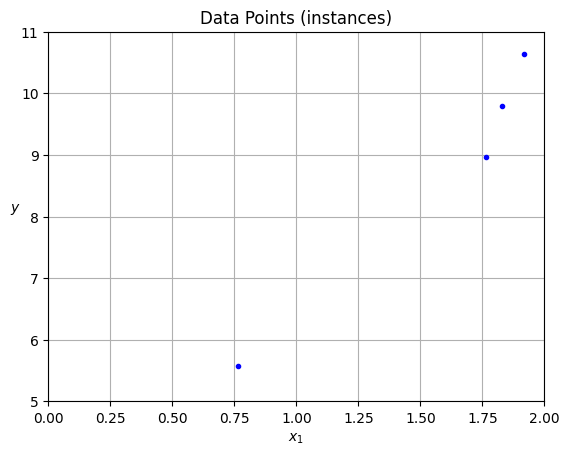

In [6]:
def plot_data_points(X, y):
    plt.plot(X, y.detach().numpy(), "b.")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0)
    plt.title("Data Points (instances)")
    plt.axis([X_RANGE['min'], X_RANGE['max'], floor(y.min()), ceil(y.max())])
    plt.grid()
    plt.show()
    return

plot_data_points(X, y)

### Preprocessing the Data

Now we are adding a dummy input parameter, that is equal to one for all instances: $x_0=1$.
This will allow us to use a single matrix multiplication for the equation $y =  w_0*1 + w_1*x_1$. It  is the genric form of a 1-dimensional linear equation. 

(for additional optional context, see: [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.add_dummy_feature.html))

In [7]:
X_extended = torch.cat((torch.full(X.shape, 1), X), 1)

In [8]:
h.print_tensor_info(X_extended, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[1.0000, 1.7645],
        [1.0000, 1.8300],
        [1.0000, 0.7657],
        [1.0000, 1.9186]])
Dimension    2
Shape        (4, 2)


### Defining the Model
Now we can define the parameters: $w_0$ and $w_1$ of the linear equation.
The linear equation is $y = w_0*x_0 + w_1*x_1$ (in a matrix notation: $y = X @ W$).

In [9]:
def model(X, W):
    return X @ W

Let's define the $W$ tensor and initalize its values.

**Note that compared to the previous notebook, here we add `required_grad` to let PyTorch know that this is a parameter that the loss function should have its gradient calculated with respect to this parameter (more on this below).**

In [10]:
W = torch.tensor([[1.], [2.]], requires_grad=True)

In [11]:
h.print_tensor_info(W, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[1.],
        [2.]], requires_grad=True)
Dimension    2
Shape        (2, 1)


In [12]:
def predict(X: torch.Tensor, W: torch.Tensor, is_preprocessed:bool=False) -> torch.Tensor:
    """
    Calculates the value of a linear function (defined by the parameters W), at points X.
    Parameters:
    ----------
    X: torch tensor of shape (number_of_points_to_predict, 1), representing the x-values of the points to predict
    W: torch tensor of shape (2, 1), representing the parameters of the linear function w_0 and w_1
    is_preprocessed: bool, indicating whether the data has been preprocessed (i.e. whether the first column of X has been set to 1)
    Returns:
    -------
    y_predicted: a torch tensor of shape (number_of_points_to_predict, 1), representing the predicted y-values of the points according to the linear function
    """
    if is_preprocessed:
        X_extended = X
    else:
        X_extended = torch.cat((torch.full(X.shape, 1), X), 1)  # preprocess
    y_predicted = model(X_extended, W)
    return y_predicted

In [13]:
y_predicted = predict(X_extended, W, is_preprocessed=True)

In [14]:
h.print_tensor_info(y_predicted, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[4.5291],
        [4.6600],
        [2.5315],
        [4.8372]], grad_fn=<MmBackward0>)
Dimension    2
Shape        (4, 1)


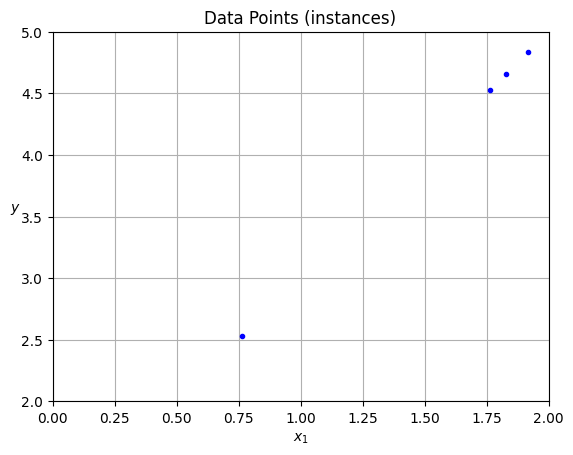

In [15]:
plot_data_points(X, y_predicted)

### Setting up a Loss Function
A loss function represents the value to be optimized.

Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

To visualize it, let's plot the data points and the predictions on the same graph: 

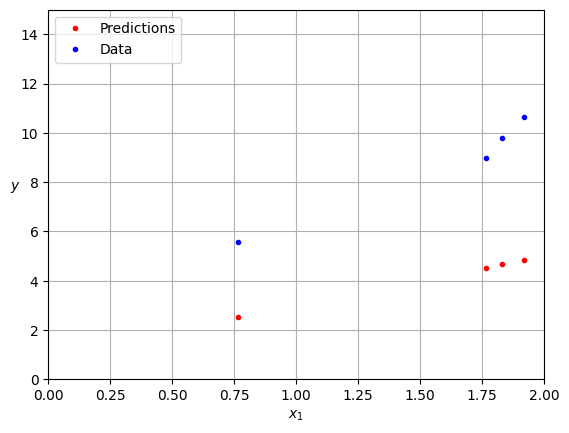

In [16]:
plt.plot(X, y_predicted.detach().numpy(), "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([X_RANGE['min'], X_RANGE['max'], 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

The loss function we are going to use is the mean squared error (MSE):

$\frac{1}{m}*\sum_{n=1} ^{m} (y_{predicted, n} - y_n)^2$

In [17]:
def loss_fn(y_predicted, y):
    mse = ((y_predicted - y) ** 2).mean()  # mean squared error. This is equivalent to: torch.sum((y_predicted - y)**2)/y.numel()
    return mse

The MSE calculation can be broken down into two stages:
1. Calculating the square of eachof the differences of the predicted minus the expected value
2. Calculating the mean of these squares, across all data instances in the batch

Here are these two stages:

In [18]:
print('Squared error per instance:')
print((y_predicted - y)**2)

Squared error per instance:
tensor([[19.6771],
        [26.3445],
        [ 9.2139],
        [33.6346]], grad_fn=<PowBackward0>)


In [19]:
mse = torch.sum((y_predicted - y)**2)/y.numel()  # here we calculate the the mean based on the sum and number of elements in `y`
print(f'MSE: {mse:.4}')

MSE: 22.22


In [20]:
loss = loss_fn(y_predicted, y)
print(f'MSE: {loss:.4}')

MSE: 22.22


In [21]:
h.print_tensor_info(loss, fields=['Tensor', 'Dimension', 'Shape'])

22.217533111572266
Dimension    0
Shape        ()


### Optimization
**The key difference between the previous notebook and this one, is the way the gradient is calculated and applied to the parameters. In the previous notebook, the gradient was hand-coded by analytically deriving two partial derivatives. Instead, here we use PyTorch's automatic gradient calculation.**

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the `SGD` optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html) available in PyTorch such as `ADAM` and `RMSProp`, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter. 

In [22]:
lr = 0.01
print(f'Learning Rate: {lr:.4}')

Learning Rate: 0.01


In [23]:
optimizer = optim.SGD([W], lr=lr)

#### Running a single iteration of the gradient descent optimization
A gradient descent optimization is iterative, running for some epoches, before it potentially converges. Before running the gradient descent optimization over many iterations, let's run only a single iteration and take a look at the before/after values of the predictions ($y_predicted$) and parameters ($W$).

Each iteration has three steps: 
1. Calculate the loss
2. Backward-pass: Calculate the gradients for each of the parameters
3. Update the parameters

As we've seen above, the values of loss, the predictions, the parameters and their gradient are:

In [24]:
print('The values of the predicted y-values:')
print(y_predicted)
print('\n')
print('The loss tensor:')
print(loss)
print('\n')
print('The parameters, the W tensor:')
print(W)
print('\n')
print('The value of the gradient of the loss function with respect to the parameters W:')
print(W.grad)

The values of the predicted y-values:
tensor([[4.5291],
        [4.6600],
        [2.5315],
        [4.8372]], grad_fn=<MmBackward0>)


The loss tensor:
tensor(22.2175, grad_fn=<MeanBackward0>)


The parameters, the W tensor:
tensor([[1.],
        [2.]], requires_grad=True)


The value of the gradient of the loss function with respect to the parameters W:
None


##### Backward-pass
In the backward-pass we calculate the gradient of the loss function with respect to the parameters W. 
This is done by calling the `backward()` method on the loss tensor. 
This will calculate the gradient of the loss function with respect to the parameters W, and store it in the `grad` field of the W tensor.

In [25]:
loss.backward()

What was the action of this operation? Let's see below:

In [26]:
print('The loss tensor:')
print(loss)
print('\n')
print('The parameters, the W tensor:')
print(W)
print('\n')
print('The value of the gradient of the loss function with respect to the parameters W is:')
print(W.grad)


The loss tensor:
tensor(22.2175, grad_fn=<MeanBackward0>)


The parameters, the W tensor:
tensor([[1.],
        [2.]], requires_grad=True)


The value of the gradient of the loss function with respect to the parameters W is:
tensor([[ -9.2018],
        [-15.3358]])


 Note that only the `grad` attribute was updated, but the values of the parameters (and of the loss function) haven't been affected.

##### Update the parameters
In the next step we can actually apply the gradients calculated above, using the optimizer.

All tensors that are part of the same computational graph as the loss function, and has `requires_grad=True` are being updated according to the optimizer. 

In [27]:
optimizer.step()

As seen below, the values of the parameters were updated.
Also note that the values of the gradients were not re-initialized, and their values haven't changed.

In [28]:
print('The loss tensor:')
print(loss)
print('\n')
print('The parameters, the W tensor:')
print(W)
print('\n')
print('The value of the gradient of the loss function with respect to the parameters W is:')
print(W.grad)

The loss tensor:
tensor(22.2175, grad_fn=<MeanBackward0>)


The parameters, the W tensor:
tensor([[1.0920],
        [2.1534]], requires_grad=True)


The value of the gradient of the loss function with respect to the parameters W is:
tensor([[ -9.2018],
        [-15.3358]])


We can see above that values of `w_0` and `w_1` moved in the direction of the optimal solution (which we know based on the way we created the data) 

#### Running a second iteration
In the cell below we run a second iteration, following the first one above. 
Notice that it includes two steps:
1. Reset the gradient to zero. If we were to skip the gradient reset to zero, gradients will be accumulated across multiple iterations. This is not desired, as we want to calculate the gradient for each iteration seperatly. Otherwise, previous gradients (that are not longer relevant for the updated parameters' values) will be taken into account. (the value of the gradient before the first iteration was `None`. The difference between `None` and `0` is subtle, see the [zero_grad docstring](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)).
2. Redefine the predictions (y_predicted) and loss. Question for you, the reader: Why is this needed? You can try running the code without the redefinition and see what happens.

Note: The PyTorch model is dynamic - the graph is recreated from scratch. After each `.backward()` call, autograd starts populating a new graph. This is exactly what allows you to use control flow statements in your model; you can change the shape, size and operations at every iteration if needed. ([source](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#more-on-computational-graphs))

In [29]:
optimizer.zero_grad()  # reset the gradients to zero, otherwise they will accumulate
y_predicted = model(X_extended, W)  # redefining/recalculating y_predicted, with the parametric values updated by the optimizer in the previous step
loss = loss_fn(y_predicted, y)  # redefining/recalculating the loss, with the updated y_predicted
loss.backward()
optimizer.step()

In [30]:
print(W)
print(W.grad)

tensor([[1.1774],
        [2.2956]], requires_grad=True)
tensor([[ -8.5363],
        [-14.2241]])


#### Iterative Optimization
Next, the optimization process runs iteratively. 

In [31]:
def training_loop(n_epochs:int, optimizer:torch.optim.Optimizer, W:torch.Tensor, X:torch.Tensor, y:torch.Tensor)->torch.Tensor:
    """
    Iteratively train a linear model, by updating the parameters W, using the optimizer, for n_epochs.
    Parameters:
    ----------
    n_epochs: int, the number of epochs to train the model for.
    optimizer: an optimizer object, used to update the parameters W.
    W: torch tensor of shape (2, 1), representing the parameters of the linear function w_0 and w_1, for the current iteration.
    X: torch tensor of shape (number_of_points_to_predict, 1), representing the x-values of the input data points (the instances).
    y: torch tensor of shape (number_of_points_to_predict, 1), representing the true y-values of the input data points.
    Returns:
    -------
    W: torch tensor of shape (2, 1), representing the parameters of the linear function w_0 and w_1, after training.
    """
    for epoch in range(1, n_epochs + 1):
        y_predicted = model(X, W) 
        loss = loss_fn(y_predicted, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return W

In [32]:
W = training_loop(n_epochs=100, optimizer=optimizer, W=W, X=X_extended, y=y)

Epoch 10, Loss 4.362111
Epoch 20, Loss 1.079108
Epoch 30, Loss 0.349494
Epoch 40, Loss 0.187327
Epoch 50, Loss 0.151264
Epoch 60, Loss 0.143228
Epoch 70, Loss 0.141420
Epoch 80, Loss 0.140996
Epoch 90, Loss 0.140882
Epoch 100, Loss 0.140836


In [33]:
W

tensor([[2.2825],
        [4.1082]], requires_grad=True)

In [34]:
y_predicted = model(X_extended, W)

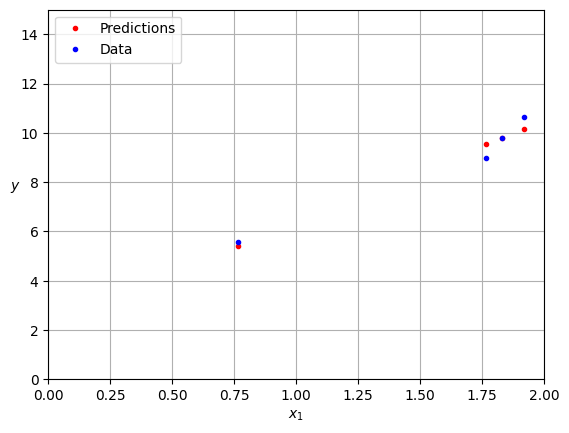

In [35]:
plt.plot(X, y_predicted.detach().numpy(), "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

In [36]:
y

tensor([[ 8.9650],
        [ 9.7927],
        [ 5.5669],
        [10.6368]])

In [37]:
y_predicted

tensor([[ 9.5316],
        [ 9.8006],
        [ 5.4283],
        [10.1646]], grad_fn=<MmBackward0>)

In [38]:
y_predicted - y

tensor([[ 0.5667],
        [ 0.0079],
        [-0.1386],
        [-0.4722]], grad_fn=<SubBackward0>)